In [1]:
# Clean up old CSV files and re-run
!rm actions_*.csv outcomes_*.csv;

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
from battle import main
main()

  1%|          | 1/100 [00:11<18:26, 11.18s/it]

Epoch 0000:  998 ± 2 wins in 6.6 + 4.5 sec


  2%|▏         | 2/100 [00:20<16:21, 10.02s/it]

Epoch 0001:  1000 ± 0 wins in 5.1 + 4.1 sec


  3%|▎         | 3/100 [00:29<15:35,  9.64s/it]

Epoch 0002:  998 ± 2 wins in 4.9 + 4.2 sec


  4%|▍         | 4/100 [00:38<14:57,  9.35s/it]

Epoch 0003:  1000 ± 0 wins in 4.8 + 4.1 sec


  5%|▌         | 5/100 [00:47<14:25,  9.11s/it]

Epoch 0004:  1000 ± 0 wins in 4.6 + 4.1 sec


  6%|▌         | 6/100 [00:55<14:01,  8.95s/it]

Epoch 0005:  998 ± 3 wins in 4.5 + 4.1 sec


  7%|▋         | 7/100 [01:04<13:44,  8.86s/it]

Epoch 0006:  999 ± 2 wins in 4.6 + 4.1 sec


  8%|▊         | 8/100 [01:13<13:32,  8.83s/it]

Epoch 0007:  1000 ± 0 wins in 4.7 + 4.1 sec


  9%|▉         | 9/100 [01:22<13:22,  8.82s/it]

Epoch 0008:  999 ± 2 wins in 4.7 + 4.1 sec


 10%|█         | 10/100 [01:30<13:13,  8.81s/it]

Epoch 0009:  1000 ± 0 wins in 4.7 + 4.1 sec


 11%|█         | 11/100 [01:39<12:59,  8.76s/it]

Epoch 0010:  1000 ± 0 wins in 4.6 + 4.0 sec


 12%|█▏        | 12/100 [01:48<12:51,  8.76s/it]

Epoch 0011:  1000 ± 0 wins in 4.7 + 4.0 sec


 13%|█▎        | 13/100 [01:56<12:36,  8.70s/it]

Epoch 0012:  999 ± 2 wins in 4.4 + 4.1 sec


 14%|█▍        | 14/100 [02:05<12:26,  8.68s/it]

Epoch 0013:  1000 ± 0 wins in 4.7 + 4.0 sec


 15%|█▌        | 15/100 [02:14<12:21,  8.72s/it]

Epoch 0014:  1000 ± 0 wins in 4.7 + 4.2 sec


 16%|█▌        | 16/100 [02:22<12:11,  8.70s/it]

Epoch 0015:  1000 ± 0 wins in 4.6 + 4.1 sec


 17%|█▋        | 17/100 [02:31<11:55,  8.62s/it]

Epoch 0016:  999 ± 2 wins in 4.5 + 4.0 sec


 18%|█▊        | 18/100 [02:39<11:47,  8.63s/it]

Epoch 0017:  1000 ± 0 wins in 4.6 + 4.1 sec


 19%|█▉        | 19/100 [02:48<11:38,  8.62s/it]

Epoch 0018:  1000 ± 0 wins in 4.5 + 4.1 sec


 20%|██        | 20/100 [02:57<11:27,  8.60s/it]

Epoch 0019:  999 ± 2 wins in 4.5 + 4.0 sec


 21%|██        | 21/100 [03:05<11:20,  8.62s/it]

Epoch 0020:  1000 ± 0 wins in 4.6 + 4.1 sec


 22%|██▏       | 22/100 [03:14<11:10,  8.60s/it]

Epoch 0021:  1000 ± 0 wins in 4.6 + 4.0 sec


 23%|██▎       | 23/100 [03:23<11:04,  8.63s/it]

Epoch 0022:  1000 ± 0 wins in 4.6 + 4.1 sec


 24%|██▍       | 24/100 [03:31<10:57,  8.65s/it]

Epoch 0023:  1000 ± 0 wins in 4.6 + 4.1 sec


 25%|██▌       | 25/100 [03:40<10:47,  8.63s/it]

Epoch 0024:  1000 ± 0 wins in 4.5 + 4.0 sec


 26%|██▌       | 26/100 [03:49<10:40,  8.65s/it]

Epoch 0025:  1000 ± 0 wins in 4.6 + 4.1 sec


 27%|██▋       | 27/100 [03:57<10:28,  8.61s/it]

Epoch 0026:  1000 ± 0 wins in 4.5 + 4.0 sec


 28%|██▊       | 28/100 [04:06<10:18,  8.59s/it]

Epoch 0027:  1000 ± 0 wins in 4.5 + 4.0 sec


 29%|██▉       | 29/100 [04:14<10:15,  8.66s/it]

Epoch 0028:  1000 ± 0 wins in 4.6 + 4.3 sec


 30%|███       | 30/100 [04:23<10:10,  8.72s/it]

Epoch 0029:  1000 ± 0 wins in 4.7 + 4.1 sec


 31%|███       | 31/100 [04:32<10:00,  8.70s/it]

Epoch 0030:  1000 ± 0 wins in 4.6 + 4.0 sec


 32%|███▏      | 32/100 [04:41<09:59,  8.82s/it]

Epoch 0031:  1000 ± 0 wins in 4.6 + 4.5 sec


 33%|███▎      | 33/100 [04:50<09:53,  8.85s/it]

Epoch 0032:  1000 ± 0 wins in 4.9 + 4.0 sec


 34%|███▍      | 34/100 [04:59<09:40,  8.79s/it]

Epoch 0033:  1000 ± 0 wins in 4.6 + 4.0 sec


 35%|███▌      | 35/100 [05:07<09:25,  8.70s/it]

Epoch 0034:  1000 ± 0 wins in 4.4 + 4.1 sec


 36%|███▌      | 36/100 [05:16<09:17,  8.71s/it]

Epoch 0035:  1000 ± 0 wins in 4.7 + 4.0 sec


 37%|███▋      | 37/100 [05:24<09:07,  8.69s/it]

Epoch 0036:  1000 ± 0 wins in 4.6 + 4.1 sec


 38%|███▊      | 38/100 [05:33<09:00,  8.72s/it]

Epoch 0037:  1000 ± 0 wins in 4.6 + 4.2 sec


 39%|███▉      | 39/100 [05:42<08:49,  8.68s/it]

Epoch 0038:  1000 ± 0 wins in 4.6 + 4.0 sec


 40%|████      | 40/100 [05:50<08:39,  8.66s/it]

Epoch 0039:  998 ± 2 wins in 4.6 + 4.0 sec


 41%|████      | 41/100 [05:59<08:31,  8.67s/it]

Epoch 0040:  1000 ± 0 wins in 4.6 + 4.1 sec


 42%|████▏     | 42/100 [06:08<08:20,  8.63s/it]

Epoch 0041:  999 ± 2 wins in 4.5 + 4.0 sec


 43%|████▎     | 43/100 [06:16<08:10,  8.61s/it]

Epoch 0042:  1000 ± 0 wins in 4.6 + 4.0 sec


 44%|████▍     | 44/100 [06:25<08:00,  8.58s/it]

Epoch 0043:  1000 ± 0 wins in 4.6 + 4.0 sec


 45%|████▌     | 45/100 [06:33<07:51,  8.58s/it]

Epoch 0044:  1000 ± 0 wins in 4.5 + 4.1 sec


 46%|████▌     | 46/100 [06:42<07:43,  8.57s/it]

Epoch 0045:  1000 ± 0 wins in 4.6 + 4.0 sec


 47%|████▋     | 47/100 [06:51<07:36,  8.60s/it]

Epoch 0046:  1000 ± 0 wins in 4.6 + 4.1 sec


 48%|████▊     | 48/100 [06:59<07:28,  8.63s/it]

Epoch 0047:  999 ± 2 wins in 4.6 + 4.1 sec


 49%|████▉     | 49/100 [07:08<07:18,  8.61s/it]

Epoch 0048:  1000 ± 0 wins in 4.6 + 4.0 sec


 50%|█████     | 50/100 [07:17<07:11,  8.62s/it]

Epoch 0049:  1000 ± 0 wins in 4.6 + 4.1 sec


 51%|█████     | 51/100 [07:25<07:02,  8.62s/it]

Epoch 0050:  999 ± 2 wins in 4.6 + 4.0 sec


 52%|█████▏    | 52/100 [07:34<06:53,  8.62s/it]

Epoch 0051:  998 ± 2 wins in 4.6 + 4.0 sec


 53%|█████▎    | 53/100 [07:42<06:44,  8.60s/it]

Epoch 0052:  1000 ± 0 wins in 4.5 + 4.1 sec


 54%|█████▍    | 54/100 [07:51<06:36,  8.62s/it]

Epoch 0053:  1000 ± 0 wins in 4.6 + 4.0 sec


 55%|█████▌    | 55/100 [07:59<06:26,  8.58s/it]

Epoch 0054:  999 ± 2 wins in 4.5 + 4.0 sec


 56%|█████▌    | 56/100 [08:08<06:15,  8.54s/it]

Epoch 0055:  1000 ± 0 wins in 4.5 + 4.0 sec


 57%|█████▋    | 57/100 [08:17<06:13,  8.68s/it]

Epoch 0056:  1000 ± 0 wins in 4.8 + 4.2 sec


 58%|█████▊    | 58/100 [08:25<06:01,  8.60s/it]

Epoch 0057:  1000 ± 0 wins in 4.4 + 4.0 sec


 59%|█████▉    | 59/100 [08:34<05:50,  8.55s/it]

Epoch 0058:  1000 ± 0 wins in 4.5 + 3.9 sec


 60%|██████    | 60/100 [08:42<05:41,  8.55s/it]

Epoch 0059:  999 ± 2 wins in 4.5 + 4.0 sec


 61%|██████    | 61/100 [08:51<05:32,  8.52s/it]

Epoch 0060:  999 ± 2 wins in 4.5 + 4.0 sec


 62%|██████▏   | 62/100 [08:59<05:25,  8.57s/it]

Epoch 0061:  1000 ± 0 wins in 4.5 + 4.1 sec


 63%|██████▎   | 63/100 [09:08<05:17,  8.58s/it]

Epoch 0062:  999 ± 2 wins in 4.6 + 4.0 sec


 64%|██████▍   | 64/100 [09:16<05:07,  8.53s/it]

Epoch 0063:  1000 ± 0 wins in 4.4 + 4.0 sec


 65%|██████▌   | 65/100 [09:25<04:57,  8.49s/it]

Epoch 0064:  1000 ± 0 wins in 4.4 + 3.9 sec


 66%|██████▌   | 66/100 [09:34<04:51,  8.57s/it]

Epoch 0065:  1000 ± 0 wins in 4.6 + 4.1 sec


 67%|██████▋   | 67/100 [09:42<04:44,  8.62s/it]

Epoch 0066:  1000 ± 0 wins in 4.6 + 4.1 sec


 68%|██████▊   | 68/100 [09:51<04:35,  8.61s/it]

Epoch 0067:  1000 ± 0 wins in 4.6 + 4.0 sec


 69%|██████▉   | 69/100 [10:00<04:27,  8.63s/it]

Epoch 0068:  1000 ± 0 wins in 4.5 + 4.1 sec


 70%|███████   | 70/100 [10:08<04:17,  8.59s/it]

Epoch 0069:  1000 ± 0 wins in 4.5 + 4.0 sec


 71%|███████   | 71/100 [10:17<04:09,  8.60s/it]

Epoch 0070:  1000 ± 0 wins in 4.6 + 4.0 sec


 72%|███████▏  | 72/100 [10:26<04:02,  8.66s/it]

Epoch 0071:  1000 ± 0 wins in 4.7 + 4.1 sec


 73%|███████▎  | 73/100 [10:34<03:52,  8.61s/it]

Epoch 0072:  1000 ± 0 wins in 4.6 + 3.9 sec


 74%|███████▍  | 74/100 [10:43<03:44,  8.62s/it]

Epoch 0073:  999 ± 2 wins in 4.5 + 4.1 sec


 75%|███████▌  | 75/100 [10:51<03:34,  8.59s/it]

Epoch 0074:  1000 ± 0 wins in 4.5 + 4.0 sec


 76%|███████▌  | 76/100 [11:00<03:26,  8.61s/it]

Epoch 0075:  1000 ± 0 wins in 4.7 + 4.0 sec


 77%|███████▋  | 77/100 [11:08<03:16,  8.53s/it]

Epoch 0076:  1000 ± 0 wins in 4.3 + 4.0 sec


 78%|███████▊  | 78/100 [11:17<03:07,  8.52s/it]

Epoch 0077:  998 ± 2 wins in 4.5 + 4.0 sec


 79%|███████▉  | 79/100 [11:25<02:59,  8.56s/it]

Epoch 0078:  1000 ± 0 wins in 4.5 + 4.2 sec


 80%|████████  | 80/100 [11:34<02:52,  8.63s/it]

Epoch 0079:  1000 ± 0 wins in 4.7 + 4.1 sec


 81%|████████  | 81/100 [11:43<02:43,  8.58s/it]

Epoch 0080:  1000 ± 0 wins in 4.4 + 4.0 sec


 82%|████████▏ | 82/100 [11:51<02:33,  8.55s/it]

Epoch 0081:  998 ± 2 wins in 4.5 + 4.0 sec


 83%|████████▎ | 83/100 [12:00<02:24,  8.53s/it]

Epoch 0082:  1000 ± 0 wins in 4.4 + 4.0 sec


 84%|████████▍ | 84/100 [12:08<02:17,  8.61s/it]

Epoch 0083:  1000 ± 0 wins in 4.7 + 4.1 sec


 85%|████████▌ | 85/100 [12:17<02:08,  8.55s/it]

Epoch 0084:  999 ± 2 wins in 4.5 + 3.9 sec


 86%|████████▌ | 86/100 [12:25<01:58,  8.49s/it]

Epoch 0085:  1000 ± 0 wins in 4.4 + 4.0 sec


 87%|████████▋ | 87/100 [12:34<01:50,  8.51s/it]

Epoch 0086:  998 ± 2 wins in 4.5 + 4.0 sec


 88%|████████▊ | 88/100 [12:42<01:42,  8.55s/it]

Epoch 0087:  1000 ± 0 wins in 4.6 + 4.1 sec


 89%|████████▉ | 89/100 [12:51<01:33,  8.52s/it]

Epoch 0088:  1000 ± 0 wins in 4.5 + 3.9 sec


 90%|█████████ | 90/100 [12:59<01:25,  8.55s/it]

Epoch 0089:  1000 ± 0 wins in 4.6 + 4.0 sec


 91%|█████████ | 91/100 [13:08<01:16,  8.54s/it]

Epoch 0090:  1000 ± 0 wins in 4.6 + 4.0 sec


 92%|█████████▏| 92/100 [13:16<01:08,  8.51s/it]

Epoch 0091:  1000 ± 0 wins in 4.4 + 4.0 sec


 93%|█████████▎| 93/100 [13:25<00:59,  8.49s/it]

Epoch 0092:  1000 ± 0 wins in 4.5 + 3.9 sec


 94%|█████████▍| 94/100 [13:33<00:51,  8.50s/it]

Epoch 0093:  1000 ± 0 wins in 4.5 + 4.0 sec


 95%|█████████▌| 95/100 [13:42<00:42,  8.53s/it]

Epoch 0094:  1000 ± 0 wins in 4.6 + 4.0 sec


 96%|█████████▌| 96/100 [13:51<00:34,  8.58s/it]

Epoch 0095:  999 ± 2 wins in 4.6 + 4.1 sec


 97%|█████████▋| 97/100 [13:59<00:25,  8.59s/it]

Epoch 0096:  1000 ± 0 wins in 4.6 + 4.0 sec


 98%|█████████▊| 98/100 [14:08<00:17,  8.52s/it]

Epoch 0097:  1000 ± 0 wins in 4.4 + 4.0 sec


 99%|█████████▉| 99/100 [14:16<00:08,  8.52s/it]

Epoch 0098:  1000 ± 0 wins in 4.5 + 4.0 sec


100%|██████████| 100/100 [14:25<00:00,  8.65s/it]

Epoch 0099:  1000 ± 0 wins in 4.6 + 4.0 sec


In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as pn
rnd = np.random.default_rng()

In [4]:
def load(p):
    df = pd.read_csv(p)
    df['csv'] = str(p)
    return df

df = pd.concat([load(x) for x in Path().glob("outcomes_*.csv") if x.stat().st_size > 1000], ignore_index=True)
df.team = np.array(['PCs', 'monsters'])[df.team]
df.head()

,epoch,encounter,num_rounds,actor,team,team_win,max_hp,final_hp,csv
0,0,0,10,Goblin 3,monsters,False,8,0,outcomes_15780.csv
1,0,0,10,Fighter 1,PCs,True,20,20,outcomes_15780.csv
2,0,0,10,Goblin 1,monsters,False,11,0,outcomes_15780.csv
3,0,0,10,Goblin 2,monsters,False,2,0,outcomes_15780.csv
4,0,1,4,Fighter 1,PCs,True,20,20,outcomes_15780.csv


How injured does each actor end up?

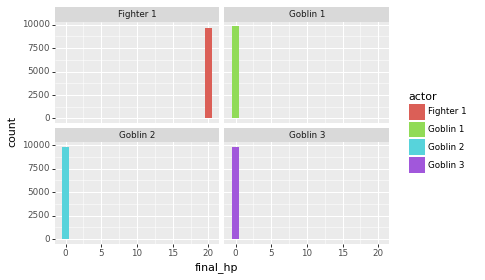

<ggplot: (176943164763)>

In [5]:
x = df[df.epoch > df.epoch.max()-10].copy() # last 10 epochs
#x = x.groupby(['epoch', 'encounter', 'csv', 'team']).sum()
#x['frac_hp'] = x.final_hp / x.max_hp
x = x.reset_index()
#pn.qplot('max_hp', data=x, geom='histogram', fill='actor', binwidth=1) + pn.facet_wrap('actor')
pn.qplot('final_hp', data=x, geom='histogram', fill='actor', binwidth=1) + pn.facet_wrap('actor')

In [18]:
def load(p):
    df = pd.read_csv(p)
    df['csv'] = str(p)
    return df

df = pd.concat([load(x) for x in Path().glob("actions_*.csv") if x.stat().st_size > 1000], ignore_index=True)
df.head(20)

,epoch,encounter,round,actor,action,target,t_fullDefense,t_weakest,raw_hp,obs_hp,csv
0,0,0,0,Goblin 3,Full Defense,Goblin 3,False,False,0,0,actions_15780.csv
1,0,0,0,Fighter 1,Longbow,Goblin 3,True,False,-19,-8,actions_15780.csv
2,0,0,0,Goblin 1,Small Scimitar,Fighter 1,False,True,0,0,actions_15780.csv
3,0,0,0,Goblin 2,Full Defense,Goblin 2,False,False,0,0,actions_15780.csv
4,0,0,1,Fighter 1,Longbow,Goblin 1,False,False,0,0,actions_15780.csv
5,0,0,1,Goblin 1,Full Defense,Goblin 1,False,False,0,0,actions_15780.csv
6,0,0,1,Goblin 2,Full Defense,Goblin 2,False,False,0,0,actions_15780.csv
7,0,0,2,Fighter 1,Greatsword,Goblin 2,True,True,0,0,actions_15780.csv
8,0,0,2,Goblin 1,Small Scimitar,Fighter 1,False,True,0,0,actions_15780.csv
9,0,0,2,Goblin 2,Full Defense,Goblin 2,False,False,0,0,actions_15780.csv


How long do battles typically last, as a function of epoch?

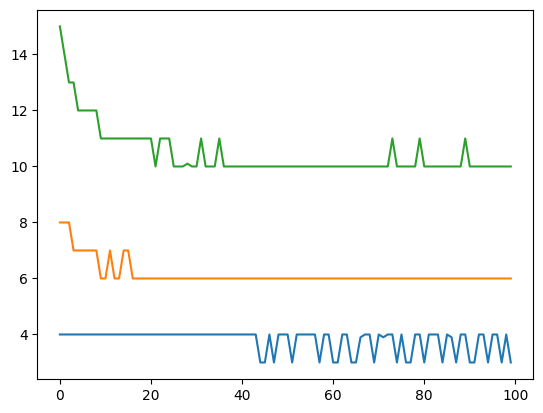

In [7]:
x = df.groupby(['epoch', 'encounter', 'csv'])['round'].max().groupby('epoch')
y = x.quantile(0.1)+1; plt.plot(y.index, y)
y = x.quantile(0.5)+1; plt.plot(y.index, y)
y = x.quantile(0.9)+1; plt.plot(y.index, y)

How often do we choose each possible action, as a function of time?

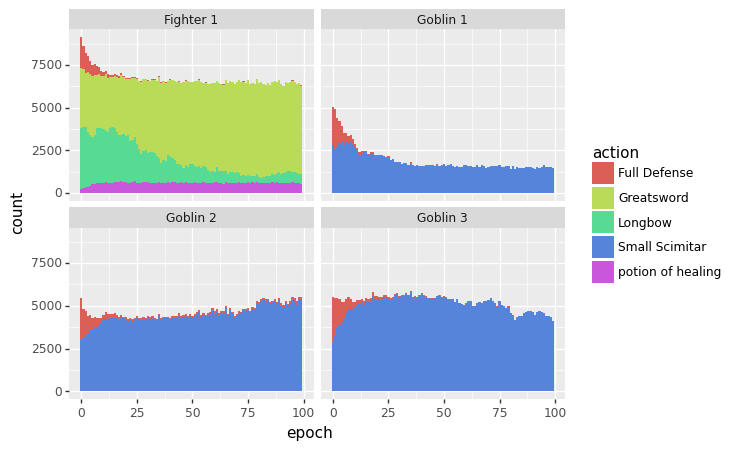

<ggplot: (176947067070)>

In [8]:
pn.qplot('epoch', data=df, fill='action', geom='histogram', binwidth=1) + pn.facet_wrap('actor')

Close-up from final epoch:

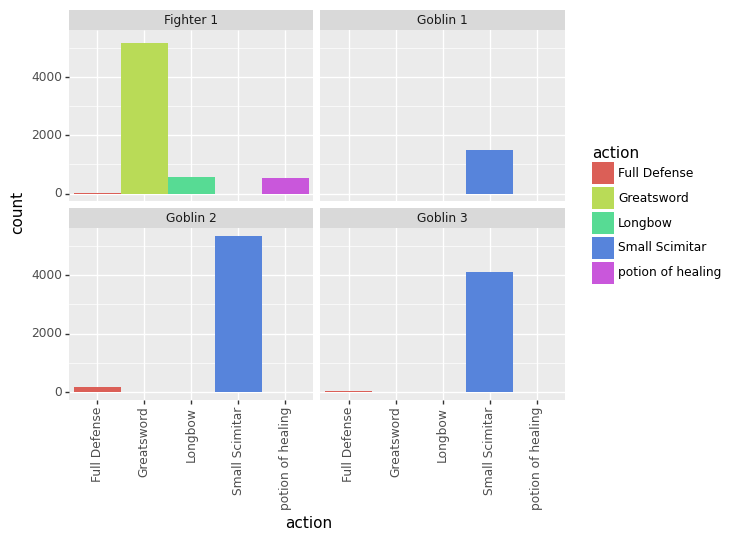

<ggplot: (176946980030)>

In [9]:
x = df[df.epoch == df.epoch.max()]
pn.qplot('action', data=x, fill='action', geom='histogram', binwidth=1) + pn.facet_wrap('actor') + pn.theme(axis_text_x=pn.element_text(rotation=90))

Do we use our healing potions more effectively as time goes on?

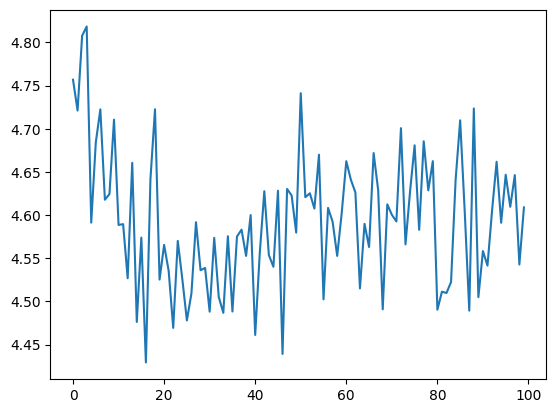

In [10]:
# Mean effect?
x = df.query('raw_hp > 0').groupby('epoch')['obs_hp'].mean()
plt.plot(x.index, x)
# How often do we use it when we're uninjured?  Not often, it's forbidden.
# x = df.query('raw_hp > 0 and obs_hp == 0').groupby('epoch').count()
# plt.plot(x.index, x.obs_hp)

Which enemy does each character attack?

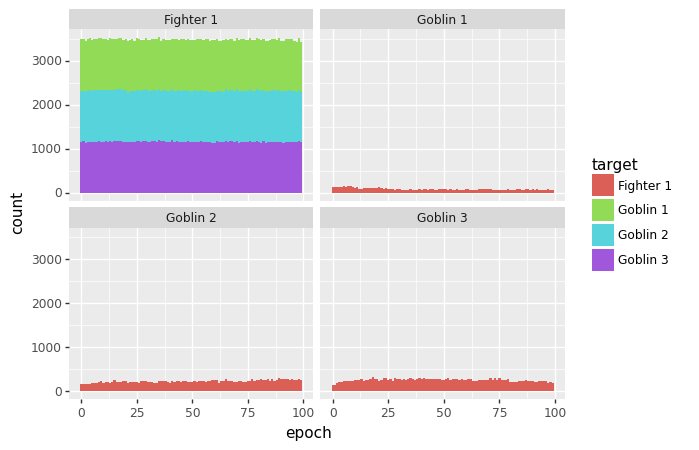

<ggplot: (176947455651)>

In [11]:
x = df.query('raw_hp < 0')
pn.qplot('epoch', data=x, fill='target', geom='histogram', binwidth=1) + pn.facet_wrap('actor')

How often do we target the weakest enemy?

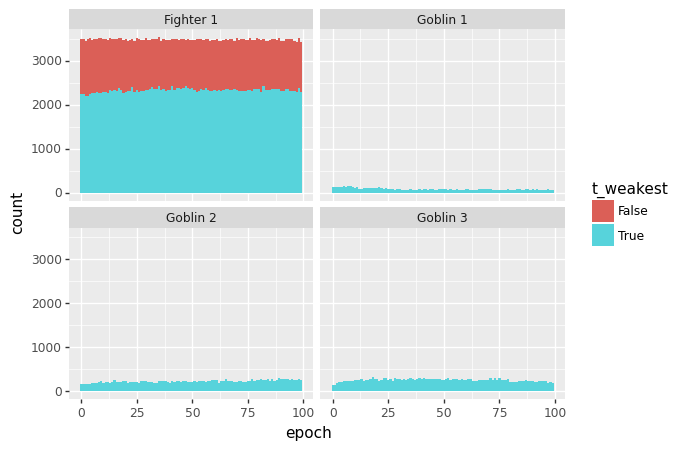

<ggplot: (176946951431)>

In [12]:
x = df.query('raw_hp < 0')
pn.qplot('epoch', data=x, fill='t_weakest', geom='histogram', binwidth=1) + pn.facet_wrap('actor')

How often do we switch targets within an encounter?

In [13]:
x = df.query('actor == "Hero" and action == "long sword"').copy()
#x['round2'] = x.groupby(['epoch', 'encounter', 'csv'])['round'].rank().astype('int')
# Convert target to numerical values
x['tgt'] = pd.Categorical(x.target).codes
# Detect changes in target
x['change_tgt'] = (x.groupby(['epoch', 'encounter', 'csv'])['tgt'].diff() != 0)
x.head()
#dir(x.tgt.cat)

,epoch,encounter,round,actor,action,target,t_fullDefense,t_weakest,raw_hp,obs_hp,csv,tgt,change_tgt


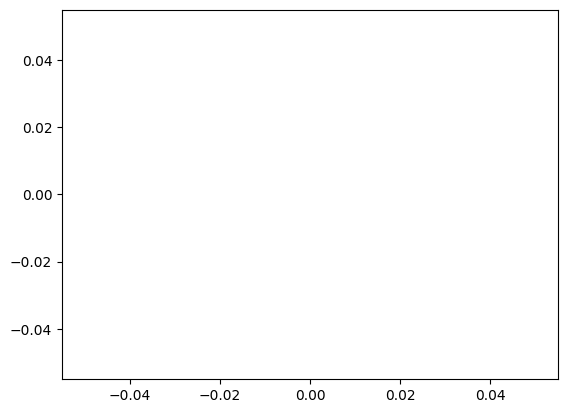

In [14]:
# Minimum is 2 (for a win):  initial attack, and switch to second target
y = x.groupby('epoch')['change_tgt'].sum() / 1000
plt.plot(y.index, y)

Which enemy do we attack first?

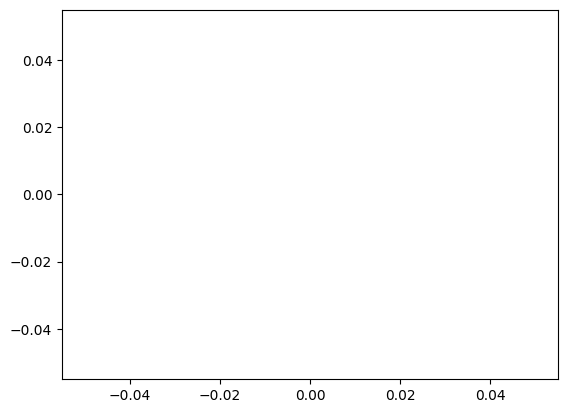

In [15]:
y = x.query('round == 0').groupby('epoch')['tgt'].mean()
plt.plot(y.index, y)

Look at a random encounter from the final epoch of training...

In [16]:
x = df[(df.epoch == df.epoch.max()) & (df.csv == rnd.choice(df.csv))]
x = x[x.encounter == rnd.choice(x.encounter)]
x

,epoch,encounter,round,actor,action,target,t_fullDefense,t_weakest,raw_hp,obs_hp,csv
1855113,99,181,0,Goblin 3,Small Scimitar,Fighter 1,False,True,0,0,actions_2052.csv
1855114,99,181,0,Goblin 1,Small Scimitar,Fighter 1,False,True,0,0,actions_2052.csv
1855115,99,181,0,Goblin 2,Full Defense,Goblin 2,False,False,0,0,actions_2052.csv
1855116,99,181,0,Fighter 1,Greatsword,Goblin 1,False,False,0,0,actions_2052.csv
1855117,99,181,1,Goblin 3,Small Scimitar,Fighter 1,False,True,0,0,actions_2052.csv
1855118,99,181,1,Goblin 1,Small Scimitar,Fighter 1,False,True,0,0,actions_2052.csv
1855119,99,181,1,Goblin 2,Small Scimitar,Fighter 1,False,True,0,0,actions_2052.csv
1855120,99,181,1,Fighter 1,Greatsword,Goblin 1,False,False,0,0,actions_2052.csv
1855121,99,181,2,Goblin 3,Small Scimitar,Fighter 1,False,True,0,0,actions_2052.csv
1855122,99,181,2,Goblin 1,Small Scimitar,Fighter 1,False,True,0,0,actions_2052.csv


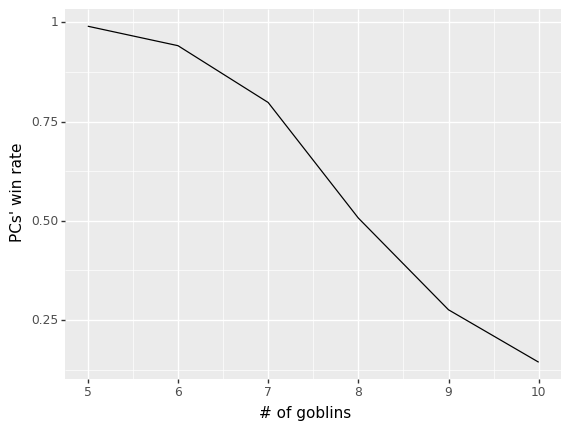

<ggplot: (176947991179)>

In [17]:
# Wins and losses at 2nd level:  2 fighters and 2 wizards vs. X goblins
pc_win_rate = {
    5: 990/1000, # 1:30
    6: 941/1000, # 1:45
    7: 798/1000, # 2:10
    8: 507/1000,
    9: 276/1000, # 3:20
    10: 144/1000, # 4 hours to train
}
#plt.plot(pc_win_rate.keys(), pc_win_rate.values())
pn.qplot(list(pc_win_rate.keys()), list(pc_win_rate.values()), geom='line', xlab='# of goblins', ylab="PCs' win rate")